In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy.io import loadmat

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision

from PIL import Image
from utils import select_device, draw_gaze

from face_detection import RetinaFace
from model import L2CS

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def getArch(arch,bins):
    # Base network structure
    if arch == 'ResNet18':
        model = L2CS( torchvision.models.resnet.BasicBlock,[2, 2,  2, 2], bins)
    elif arch == 'ResNet34':
        model = L2CS( torchvision.models.resnet.BasicBlock,[3, 4,  6, 3], bins)
    elif arch == 'ResNet101':
        model = L2CS( torchvision.models.resnet.Bottleneck,[3, 4, 23, 3], bins)
    elif arch == 'ResNet152':
        model = L2CS( torchvision.models.resnet.Bottleneck,[3, 8, 36, 3], bins)
    else:
        if arch != 'ResNet50':
            print('Invalid value for architecture is passed! '
                'The default value of ResNet50 will be used instead!')
        model = L2CS( torchvision.models.resnet.Bottleneck, [3, 4, 6,  3], bins)
    return model

In [3]:
cudnn.enabled = True
arch='ResNet50'
batch_size = 1
cam = 0
gpu = select_device('0', batch_size=batch_size)
snapshot_path = 'models/L2CSNet/Gaze360/L2CSNet_gaze360.pkl'

In [4]:
transformations = transforms.Compose([
        transforms.Resize(448),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

In [5]:
model=getArch(arch, 90)
print('Loading snapshot')
saved_state_dict = torch.load(snapshot_path)
model.load_state_dict(saved_state_dict)
model.cuda(gpu)
model.eval()

Loading snapshot


L2CS(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

In [6]:
softmax = nn.Softmax(dim=1)
detector = RetinaFace(gpu_id=0)
idx_tensor = [idx for idx in range(90)]
idx_tensor = torch.FloatTensor(idx_tensor).cuda(gpu)
x=0

In [14]:
def detect_face_and_predict_gaze(img):
    with torch.no_grad():
        faces = detector(img)
        if faces is not None:
            # print("Faces Detected")
            face = faces[0]
            # print(face)
            box, landmarks, score = face
            # print(box, landmarks, score) 
            if score > .95:
                # print("Score > 0.95")
                x_min=int(box[0])
                if x_min < 0:
                    x_min = 0
                y_min=int(box[1])
                if y_min < 0:
                    y_min = 0
                x_max=int(box[2])
                y_max=int(box[3])
                bbox_width = x_max - x_min
                bbox_height = y_max - y_min

                img_out = img.copy()

                # Crop Face
                img = img[y_min:y_max, x_min:x_max]
                img = cv2.resize(img, (224, 224))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                im_pil = Image.fromarray(img)
                img = transformations(im_pil)
                img  = Variable(img).cuda(gpu)
                img  = img.unsqueeze(0)

                # Output Cropped Face

                img_out = img_out[y_min:y_max, x_min:x_max]
                img_out = cv2.resize(img_out, (448, 448))
                # img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)

                gaze_pitch, gaze_yaw = model(img)
                
                pitch_predicted = softmax(gaze_pitch)
                yaw_predicted = softmax(gaze_yaw)
                
                # Get continuous predictions in degrees.
                pitch_predicted = torch.sum(pitch_predicted.data[0] * idx_tensor) * 4 - 180
                yaw_predicted = torch.sum(yaw_predicted.data[0] * idx_tensor) * 4 - 180
                
                pitch_predicted = pitch_predicted.cpu().detach().numpy()* np.pi/180.0
                yaw_predicted = yaw_predicted.cpu().detach().numpy()* np.pi/180.0

                # print(pitch_predicted, yaw_predicted)
                # img_out = draw_gaze(x_min,y_min,bbox_width, bbox_height, img_out, (pitch_predicted,yaw_predicted), color=(0,0,255))
                return pitch_predicted, yaw_predicted, x_min, y_min, bbox_width, bbox_height, img_out

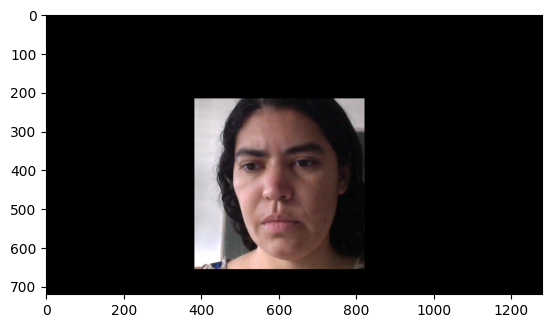

In [15]:
img_path = '../data/MPIIFaceGaze/p00/day01/0030.jpg'
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

(448, 448, 3) 0.18516799269655537 -0.1751798070282132


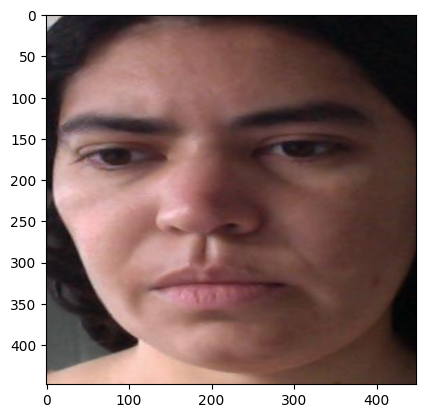

In [16]:
pitch, yaw, xmin, ymin, bboxw, bboxh, img_out = detect_face_and_predict_gaze(img)
print(img_out.shape, pitch, yaw)
plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))

In [25]:
def preprocess_data(folders, in_path, out_path):
    labels = []
    num = 1

    for folder in os.listdir(in_path):

        if folder in folders:
            print("Folder: {0}".format(folder))
            print("########")

            # calibration
            screenSize_path = os.path.join(in_path, folder, 'Calibration/screenSize.mat')
            screenSize = loadmat(screenSize_path)
            h_mm, w_mm, h_pixel, w_pixel = screenSize['height_mm'], screenSize['width_mm'], screenSize['height_pixel'], screenSize['width_pixel']

            labels_path = os.path.join(in_path, folder, folder + '.txt')
            with open(labels_path, 'r') as f:
                data = f.readlines()
            data = np.array([x.split(' ') for x in data])

            for d,day in enumerate(os.listdir(os.path.join(in_path, folder))):
                if day == 'Calibration' or day[0] != 'd':
                    continue
                for idx, t in enumerate(os.listdir(os.path.join(in_path, folder, day))):
                    # print("Num: {0}".format(num))
                    img = cv2.imread(os.path.join(in_path, folder, day, t), cv2.COLOR_BGR2RGB)
                    
                    temp = day + '/' + t
                    print(temp)
                    row = np.where(data[:, 0] == temp)[0]
                    gaze_location = data[row, 1:3][0]
                    # print("Gaze Location | X: {0} Y:{1}".format(gaze_location[0], gaze_location[1]))
                    
                    # crop face
                    pitch, yaw, x_min, y_min, bbox_width, bbox_height, img_out = detect_face_and_predict_gaze(img)
                    # print("Predicted | Pitch: {0} Yaw: {1}".format(pitch, yaw))

                    img_name = str(num) + '.jpg'
                    
                    if not os.path.exists(os.path.join(out_path, 'Images', folder)):
                        os.makedirs(os.path.join(out_path, 'Images', folder))
                        
                    cv2.imwrite(os.path.join(out_path, 'Images', folder, img_name), img_out)
                    gxn, gyn = gaze_location[0].astype('float') / w_pixel, gaze_location[1].astype('float') / h_pixel

                    # print("Gaze Nomalized | X: {0} Y: {1}".format(gxn[0][0], gyn[0][0]))
                    gaze_data = [img_name, pitch, yaw, x_min, y_min, bbox_width, bbox_height, gaze_location[0], gaze_location[1], w_pixel[0][0], h_pixel[0][0], gxn[0][0], gyn[0][0]]
                    print("Gaze Data | {0}".format(gaze_data))
                    labels.append(gaze_data)
                    num = num + 1
                    print("########")
            print(f'{folder} done...')
            
            # print("Labels: {0}".format(labels))

            # # Save the labels
            labels = np.array(labels)
            
            np.save(os.path.join(out_path , folder + ".npy") , labels)

            columns = ["filename", "pitch", "yaw", "xmin", "ymin", "bboxw", "bboxh", "gazex", "gazey", "width", "height", "gazenx", "gazeny"]
            df = pd.DataFrame(labels, columns=columns)
            df.to_csv(os.path.join(out_path, folder + ".csv"), index=False)

In [47]:
in_path = '..\data\MPIIFaceGaze'
out_path = '..\data\MPIIFaceGazeCustom'

# folders = ['p00','p01','p02','p03', 'p04', 'p05','p06','p07','p08','p09','p10','p11','p12','p13','p14']
folders = ['p14']
preprocess_data(folders, in_path, out_path)


Folder: p14
########
day01/0001.jpg
Gaze Data | ['1.jpg', -0.18163104845282116, -0.2906661898028453, 545, 104, 283, 381, '122', '641', 1440, 900, 0.08472222222222223, 0.7122222222222222]
########
day01/0002.jpg
Gaze Data | ['2.jpg', 0.2545230990688349, -0.294724314671908, 504, 94, 290, 393, '1326', '450', 1440, 900, 0.9208333333333333, 0.5]
########
day01/0003.jpg
Gaze Data | ['3.jpg', 0.06828611351072174, -0.22021705685476123, 516, 94, 291, 397, '912', '332', 1440, 900, 0.6333333333333333, 0.3688888888888889]
########
day01/0004.jpg
Gaze Data | ['4.jpg', -0.2707785017304606, -0.2998788629617564, 531, 106, 283, 390, '39', '716', 1440, 900, 0.027083333333333334, 0.7955555555555556]
########
day01/0005.jpg
Gaze Data | ['5.jpg', -0.19511489936800133, -0.22333721638789805, 534, 98, 292, 407, '54', '411', 1440, 900, 0.0375, 0.45666666666666667]
########
day01/0006.jpg
Gaze Data | ['6.jpg', 0.10666253113487258, -0.17769782583888313, 514, 97, 306, 405, '945', '219', 1440, 900, 0.65625, 0.2433

# Test Preprocessing

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
data_root = '..\\data\\MPIIFaceGazeCustom'

In [ ]:
df = pd.read_csv(data_root + '\\labels.csv')
df.head()

In [ ]:
index = 3
scale = 448

data = df.iloc[index].tolist()

img = cv2.imread(data_root + '\\Images\\' + data[0])
img = cv2.flip(img, 1)

plt.plot(float(data[-2]) * scale, float(data[-1]) * scale, 'ro')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


In [ ]:
def draw_gaze(a,b,c,d,image_in, pitchyaw, thickness=2, color=(255, 255, 0),sclae=2.0):
    """Draw gaze angle on given image with a given eye positions."""
    print("Drawing Gaze")
    image_out = image_in
    (h, w) = image_in.shape[:2]
    length = w/2
    pos = (int(a+c / 2.0), int(b+d / 2.0))
    if len(image_out.shape) == 2 or image_out.shape[2] == 1:
        image_out = cv2.cvtColor(image_out, cv2.COLOR_GRAY2BGR)
    dx = -length * np.sin(pitchyaw[0]) * np.cos(pitchyaw[1])
    dy = -length * np.sin(pitchyaw[1])
    cv2.arrowedLine(image_out, tuple(np.round(pos).astype(np.int32)),
                   tuple(np.round([pos[0] + dx, pos[1] + dy]).astype(int)), color,
                   thickness, cv2.LINE_AA, tipLength=0.18)
    return image_out    

In [ ]:
imgout = draw_gaze(data[3], data[4], data[5], data[6], img, (data[1], data[2]), color=(0,0,255))
plt.imshow(imgout)